# Homework: Prediction and Classification


---


# Introduction

In this assignment I will be using regression and classification to explore different data sets.  

**First**: I will use data from before 2002 in the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) to create a metric for picking baseball players using linear regression. This database contains the "complete batting and pitching statistics from 1871 to 2013, plus fielding statistics, standings, team stats, managerial records, post-season data, and more". [Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

**Second**: I will use the famous [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) data set to perform a $k$-neareast neighbor classification using cross validation.  While it was introduced in 1936, it is still [one of the most popular](http://archive.ics.uci.edu/ml/) example data sets in the machine learning community. Wikipedia describes the data set as follows: "The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres." Here is an illustration what the four features measure:

**Third**: I will investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The [digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).  This data set is similar to the MNIST data set discussed in the lecture. The main difference is, that each digit is represented by an 8x8 pixel image patch, which is considerably smaller than the 28x28 pixels from MNIST. In addition, the gray values are restricted to 16 different values (4 bit), instead of 256 (8 bit) for MNIST. 



---

## Load Python modules

In [1]:
%matplotlib inline 

import requests
import itertools
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import combinations
from io import StringIO 

import sklearn.datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

# Problem 1: Sabermetrics

Using data preceding the 2002 season pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary). Predict how many games this team would win in a 162 game season.  

In this problem we will be returning to the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics).  From this database, we will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. I will explore the data in this database from before 2002 and create a metric for picking players. 

#### Problem 1(a) 

Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [2]:
teams = pd.read_csv('Teams.csv')
players = pd.read_csv('Batting.csv')
salaries = pd.read_csv('Salaries.csv')
fielding = pd.read_csv('Fielding.csv')
master = pd.read_csv('Master.csv')

#### Problem 1(b)

Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player. Show the head of the `medianSalaries` DataFrame.   

In [3]:
medianSalaries = master.merge(salaries, on='playerID').groupby(['playerID', 'nameFirst',
                                                                'nameLast']).agg({'salary': np.median})
medianSalaries.head()

,,,salary
playerID,nameFirst,nameLast,
aardsda01,David,Aardsma,419000.0
aasedo01,Don,Aase,612500.0
abadan01,Andy,Abad,327000.0
abadfe01,Fernando,Abad,451500.0
abbotje01,Jeff,Abbott,255000.0


#### Problem 1(c)

Now, consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. Create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats plus hit by pitches plus sacrifice flies.

In [4]:
teams['PA'] = teams[['AB', 'BB', 'HBP', 'SF']].sum(axis=1)
teams['1BPPA'] = (teams.H-teams['2B']-teams['3B']-teams.HR) / teams.PA
teams['2BPPA'] = teams['2B'] / teams.PA
teams['3BPPA'] = teams['3B'] / teams.PA
teams['HRPPA'] = teams.HR / teams.PA
teams['BBPPA'] = teams.BB / teams.PA
stats = teams.query('yearID > 1946 & G == 162')[['teamID', 'yearID', 'W', '1BPPA',
                                                 '2BPPA', '3BPPA', 'HRPPA', 'BBPPA']].copy()
stats.head()

,teamID,yearID,W,1BPPA,2BPPA,3BPPA,HRPPA,BBPPA
1366,LAA,1961,70,0.147748,0.035708,0.003604,0.030958,0.111548
1367,KC1,1961,61,0.164751,0.035982,0.007829,0.014993,0.096618
1377,NYA,1962,96,0.167148,0.038536,0.004656,0.031952,0.093770
1379,LAA,1962,86,0.159482,0.038027,0.005737,0.022455,0.098672
1381,CHA,1962,85,0.165797,0.040756,0.009129,0.014998,0.101076


#### Problem 1(d)

Is there a noticeable time trend in the rates computed computed in Problem 1(c)? 

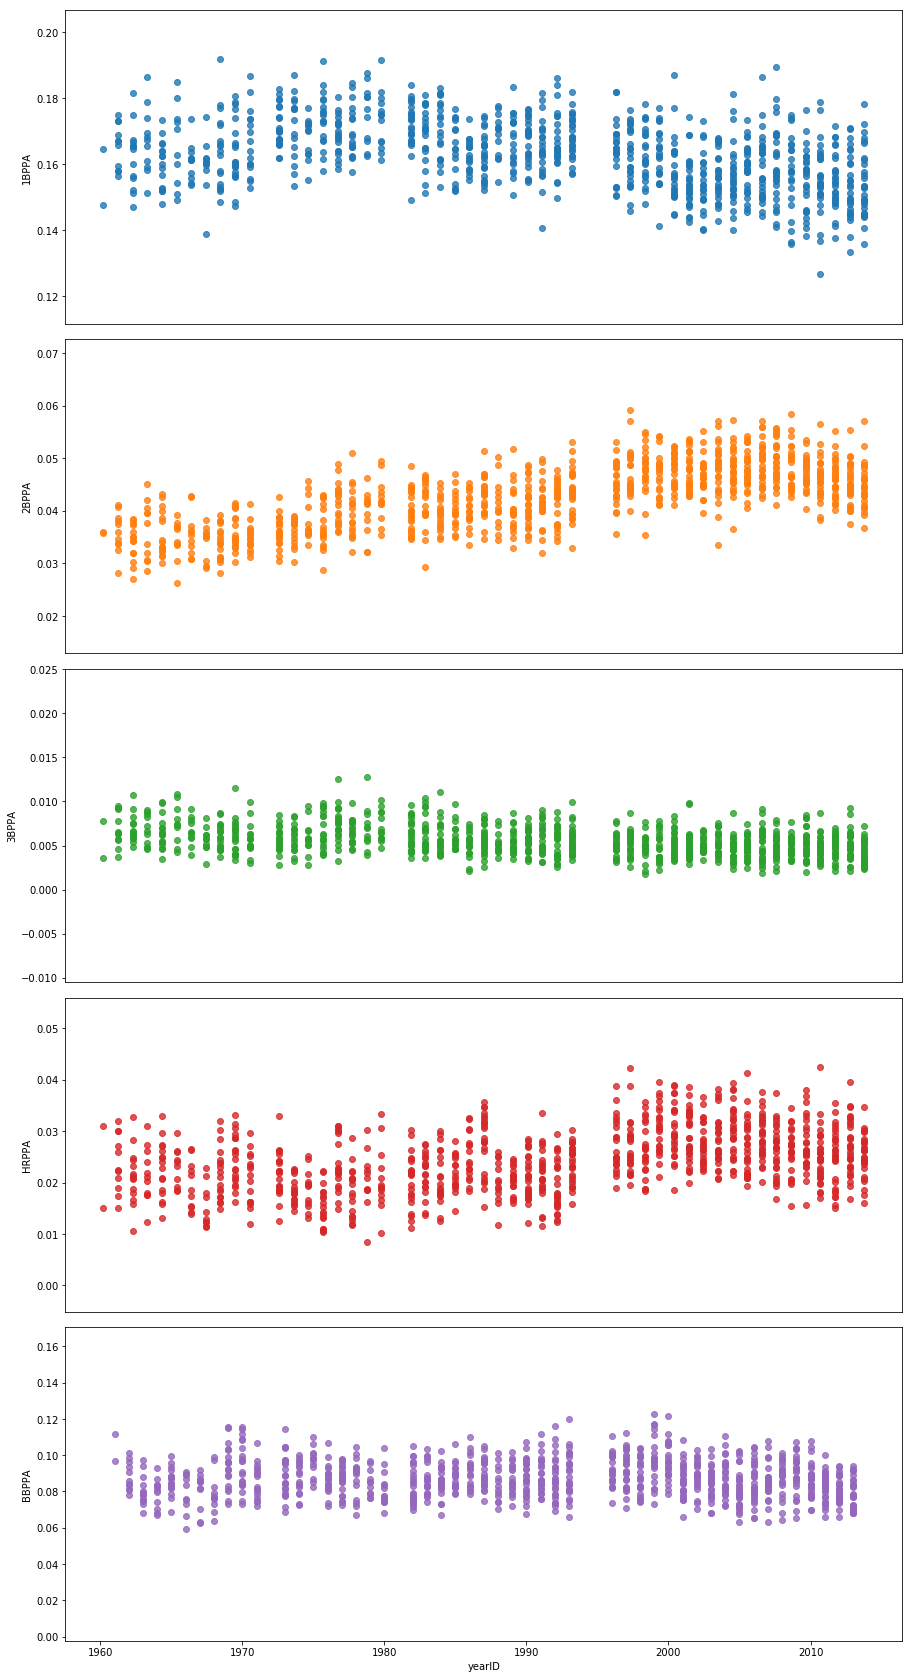

In [5]:
fig = plt.figure(figsize=(15, 30))
ax1 = fig.add_subplot('511')
ax2 = fig.add_subplot('512')
ax3 = fig.add_subplot('513')
ax4 = fig.add_subplot('514')
ax5 = fig.add_subplot('515')
for i, v in enumerate(['1BPPA', '2BPPA', '3BPPA', 'HRPPA', 'BBPPA']):
    sns.regplot(stats.yearID, stats[v], ax=eval('ax' + str(i+1)), fit_reg=False)
    if i < 4:
        eval('ax' + str(i+1)).set_xticks([])
        eval('ax' + str(i+1)).set_xlabel('')
ax5.xaxis.grid(False)
plt.subplots_adjust(hspace=.05)
plt.show()

#### Problem 1(e) 

Using the `stats` DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates. 

In [6]:
features = ['1BPPA', '2BPPA', '3BPPA', 'HRPPA', 'BBPPA']
stats[features] = stats.groupby('yearID').apply(lambda x: x[features] - x[features].mean())

#### Problem 1(f)

Build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include, fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002. Use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW). Hint: the new summary should be a linear combination of one to five of the five rates.


In [7]:
rs = {}
lrm = LinearRegression()
# List out all the possible feature combinations and calculate the cross-validation score for each
for ftrs in (x for i in range(1, len(features) + 1) for x in list(combinations(features, i))):
    rs[ftrs] = cross_val_score(lrm, stats.query('yearID < 2003')[list(ftrs)], stats.query('yearID < 2003').W,
                               scoring='neg_mean_squared_error', cv=5).mean()
# Fit the model using the best-scoring combination
best_features = list(max(rs, key = lambda key: rs[key]))
print('Best features:', best_features)
lrm.fit(stats.query('yearID < 2003')[best_features], stats.query('yearID < 2003').W)
print('Test score:', mean_squared_error(stats.query('yearID > 2002').W,
                                        lrm.predict(stats.query('yearID > 2002')[best_features])))
OPW_coef = lrm.coef_
OPW_intercept = lrm.intercept_
print('OPW_coef:', OPW_coef)
print('OPW_intercept:', OPW_intercept)

Best features: ['1BPPA', '2BPPA', '3BPPA', 'HRPPA', 'BBPPA']
Test score: 83.5007452503
OPW_coef: [  539.35023598   506.27683753  1097.93970912   858.40862336   514.59441024]
OPW_intercept: 81.0730994152


** My answer here: **OPW = 81.0730994152 + 539.35023598**1BPPA** + 506.27683753**2BPPA** + 1097.93970912**3BPPA** + 858.40862336**HRPPA** + 514.59441024**BBPPA**

#### Problem 1(g)

Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances. Consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year compute singles, doubles, triples, HR, BB per plate appearance rates. Create a new pandas DataFrame called `playerstats` that has the playerID, yearID and the rates of these stats.  Remove the average for each year as for these rates as done in Problem 1(e). 

In [8]:
players['PA'] = players[['AB', 'BB', 'HBP', 'SF']].sum(axis=1)
players['1BPPA'] = (players.H-players['2B']-players['3B']-players.HR) / players.PA
players['2BPPA'] = players['2B'] / players.PA
players['3BPPA'] = players['3B'] / players.PA
players['HRPPA'] = players.HR / players.PA
players['BBPPA'] = players.BB / players.PA
# Filter out those players with less than 500 plate appearances and yearID before 1947 or having less than 162 games
playerstats = players.query('PA > 499 & yearID in ' + str(tuple(stats.yearID)))[['playerID',
                                                                                 'yearID',
                                                                                 *features]].copy().reset_index()
# Normalise playerstats data
playerstats[features] = playerstats.groupby('yearID').apply(lambda x: x[features] - x[features].mean())
playerstats.head()

,index,playerID,yearID,1BPPA,2BPPA,3BPPA,HRPPA,BBPPA
0,14,aaronha01,1961,-0.000536,0.018306,0.006623,0.019389,-0.015251
1,15,aaronha01,1962,-0.007528,0.002868,0.001141,0.038912,0.009322
2,16,aaronha01,1963,0.002809,0.002640,-0.002337,0.036068,0.026964
3,17,aaronha01,1964,0.033591,0.009067,-0.004169,0.009121,0.011144
4,18,aaronha01,1965,-0.001090,0.024228,-0.006051,0.023228,0.008744


Show the head of the `playerstats` DataFrame. 

#### Problem 1(h)

Using the `playerstats` DataFrame created in Problem 1(g), create a new DataFrame called `playerLS` containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the average of the rates by year (a more correct way is to go back to the totals). 

In [9]:
# Calculate lifetime averages, first year, and last year of each player
playerLS = playerstats.groupby('playerID').agg(dict(**{f: np.mean for f in features}, yearID=[min, max]))
# Rename columns
playerLS.columns = playerLS.columns.droplevel(1)
year_name = {'yearID': ['year_start', 'year_end']}
playerLS.rename(columns = lambda x: year_name[x].pop(0) if x in year_name else x, inplace=True)

Show the head of the `playerLS` DataFrame. 

In [10]:
playerLS.head()

,1BPPA,HRPPA,3BPPA,2BPPA,BBPPA,year_start,year_end
playerID,,,,,,,
aaronha01,-0.011202,0.029237,-0.002128,0.007217,0.018229,1961,1975
abreubo01,-0.007056,-0.002781,0.001048,0.006722,0.050889,1998,2011
ackledu01,-0.007501,-0.014459,-0.002151,-0.015913,0.003295,2012,2012
adairje01,0.013065,-0.012864,-0.001985,0.003430,-0.037037,1962,1965
adamsru01,-0.007761,-0.017514,0.004055,-0.001524,0.003201,2005,2005


#### Problem 1(i)

Compute the OPW for each player based on the average rates in the `playerLS` DataFrame. We can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. Add this column to the playerLS DataFrame. Call this colum OPW.

In [11]:
playerLS['OPW'] = (playerLS[features] * OPW_coef).sum(axis=1) + OPW_intercept

#### Problem 1(j)

Add four columns to the `playerLS` DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF), first name, last name and median salary. 

In [12]:
playerLS = (playerLS.join(medianSalaries)
                    .join(fielding.groupby(['playerID','POS']).G.sum()
                          .groupby(['playerID']).rank(method='first', ascending=False)
                          .reset_index(1).query('G == 1.').POS))

Show the head of the `playerLS` DataFrame. 

In [13]:
playerLS.head()

,,,1BPPA,HRPPA,3BPPA,2BPPA,BBPPA,year_start,year_end,OPW,salary,POS
playerID,nameFirst,nameLast,,,,,,,,,,
abreubo01,Bobby,Abreu,-0.007056,-0.002781,0.001048,0.006722,0.050889,1998,2011,105.621378,9000000.0,OF
ackledu01,Dustin,Ackley,-0.007501,-0.014459,-0.002151,-0.015913,0.003295,2012,2012,55.893365,2400000.0,2B
adamsru01,Russ,Adams,-0.007761,-0.017514,0.004055,-0.001524,0.003201,2005,2005,67.181267,329500.0,SS
alfoned01,Edgardo,Alfonzo,0.013335,-0.006015,-0.003168,-0.002025,0.011380,1997,2004,84.454945,4112500.0,3B
alicelu01,Luis,Alicea,0.034381,-0.025568,0.007856,-0.009379,-0.005801,2000,2000,78.560965,750000.0,2B


#### Problem 1(k)

Subset the `playerLS` DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship between the median salary (in millions) and the predicted number of wins. 

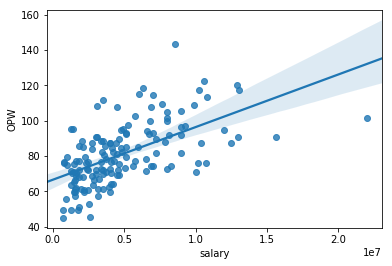

In [14]:
subls = playerLS.query('year_start < 2003 & year_end > 2002 & (year_end - year_start > 2)').reset_index()
sns.regplot(subls.salary, subls.OPW)

#### Problem 1(l)
Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.

In [15]:
picked_players = {subls.POS[idx]: subls.iloc[idx] for idx in subls.groupby('POS').OPW.idxmax()}

for idx, p in subls.sort_values('OPW', ascending=False).iterrows():
    if p.salary < picked_players[p.POS].salary:
        # Pick a new player for each position with a lower median salary
        picked_players[p.POS] = p
    else:
        continue
    if sum(p.salary for p in picked_players.values()) < 20000000:
        break
print('Averaged predicted wins:', np.mean([p.OPW for p in picked_players.values()]))
print('Total salary:', sum(p.salary for p in picked_players.values()))

Averaged predicted wins: 72.9800268064
Total salary: 24590833.5


#### Problem 1(m)
What do these players outperform in? Singles, doubles, triples, HR, or BB?

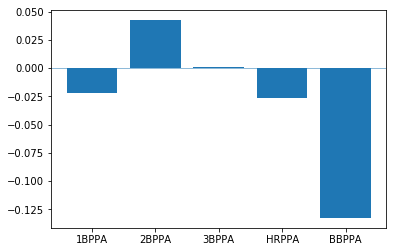

In [16]:
plt.bar(range(len(features)), [sum(p[f] for p in picked_players.values()) for f in features])
plt.xticks(range(len(features)), features)
plt.axhline(0, linewidth=.5)
plt.show()

** My answer here: ** The worst-performing set of players still costs us more than $20M. They only perform better than average in doubles.

---

# Problem 2:  $k$-Nearest Neighbors and Cross Validation 

What is the optimal $k$ for predicting species using $k$-nearest neighbor classification 
on the four features provided by the iris dataset.

In this problem we will get to know the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library. In addition to Pandas, it is one of the most useful libraries for data scientists! After completing this homework assignment we will know all the basics to get started with our own machine learning projects in sklearn. 

Future lectures will give further background information on different classifiers and their specific strengths and weaknesses, but when we have the basics for sklearn down, changing the classifier will boil down to exchanging one to two lines of code.

The data set is so popular, that sklearn provides an extra function to load it:

In [17]:
#load the iris data set
iris = sklearn.datasets.load_iris()

X = iris.data  
Y = iris.target

print(X.shape, Y.shape)

(150, 4) (150,)


#### Problem 2(a) 
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets we have created. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.67)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 4) (100,) (50, 4) (50,)


#### Problem 2(b)

Examine the data further by looking at the projections to the first two principal components of the data. Use the [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) function for this purpose, and create a scatter plot. Use the colors on the scatter plot to represent the different classes in the target data. 

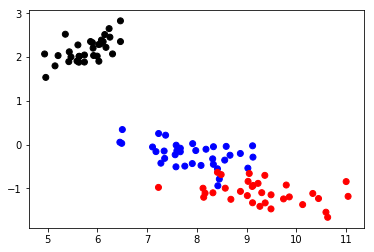

In [19]:
svd = TruncatedSVD()
transformed_X_train = svd.fit_transform(X_train)
yc = {0: 'black', 1: 'blue', 2: 'red'}
plt.scatter(transformed_X_train[:, 0], transformed_X_train[:, 1], c=[yc[x] for x in y_train])

#### Problem 2(c) 

In the lecture we discussed how to use cross validation to estimate the optimal value for $k$ (the number of nearest neighbors to base the classification on). Use ***ten fold cross validation*** to estimate the optimal value for $k$ for the iris data set. 

**Note**: For our convenience sklearn does not only include the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), but also a [grid search function](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). The function is called grid search, because if I have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set. 

In [20]:
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, param_grid={'n_neighbors': range(1, 79)}, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 79)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

#### Problem 2(d)

Visualize the result by plotting the score results versus values for $k$. 

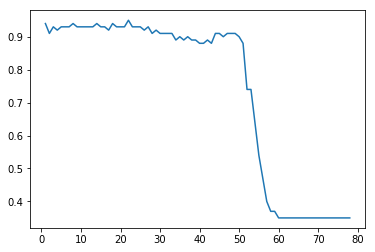

In [21]:
plt.plot(range(1, 79), grid.cv_results_['mean_test_score'])

Verify that the grid search has indeed chosen the right parameter value for $k$.

In [22]:
clf.set_params(n_neighbors=grid.best_params_['n_neighbors'])
cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)

array([ 0.95238095,  0.95238095,  0.95      ,  0.89473684,  1.        ])

#### Problem 2(e)

Test the performance of our tuned KNN classifier on the test set.

In [23]:
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.97999999999999998

---

# Problem 3: The Curse and Blessing of Higher Dimensions

In this problem we will investigate the influence of higher dimensional spaces on the classification. The data set is again one of the standard data sets from sklearn. The [digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) is similar to the MNIST data set discussed in the lecture. The main difference is, that each digit is represented by an 8x8 pixel image patch, which is considerably smaller than the 28x28 pixels from MNIST. In addition, the gray values are restricted to 16 different values (4 bit), instead of 256 (8 bit) for MNIST. 

First we again load our data set.

In [24]:
digits = sklearn.datasets.load_digits()

X = digits.data  
Y = digits.target

print(X.shape, Y.shape)

(1797, 64) (1797,)


#### Problem 3(a) 

Start with the same steps as in Problem 2. Split the data into train and test set. Use 33% of the samples as test data. Print the dimensions of all the train and test data sets I created. 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.67)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1203, 64) (1203,) (594, 64) (594,)


#### Problem 3(b) 

Similar to Problem 2(b), create a scatter plot of the projections to the first two PCs.  Use the colors on the scatter plot to represent the different classes in the target data. How well can we separate the classes?

**Hint**: Use a `Colormap` in matplotlib to represent the diferent classes in the target data. 

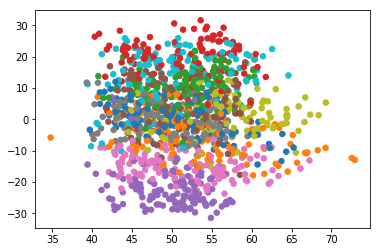

In [26]:
svd = TruncatedSVD()
transformed_X_train = svd.fit_transform(X_train)
plt.scatter(transformed_X_train[:, 0], transformed_X_train[:, 1], c=y_train, cmap='tab10', s=30)

Create individual scatter plots using only two classes at a time to explore which classes are most difficult to distinguish in terms of class separability.

/Users/Phuc/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


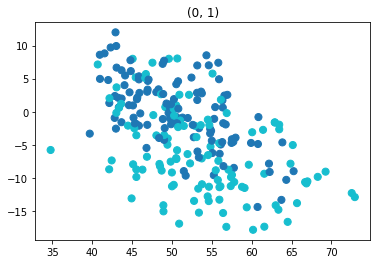

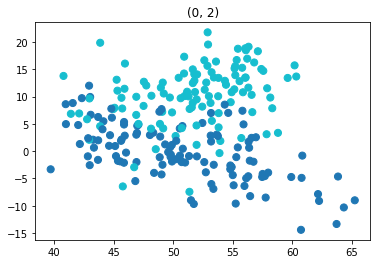

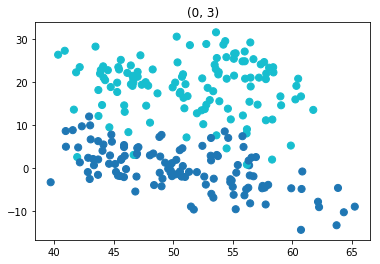

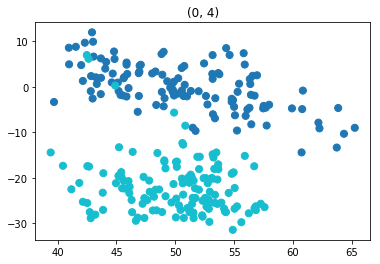

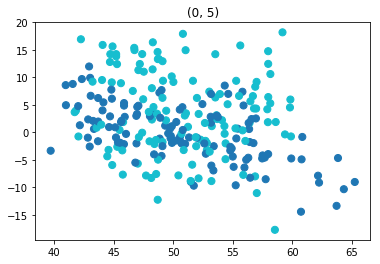

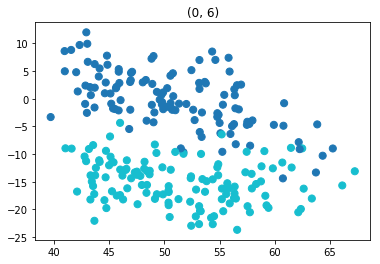

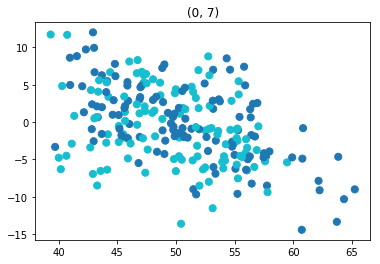

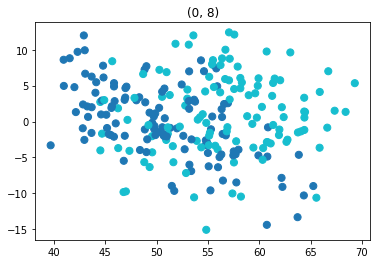

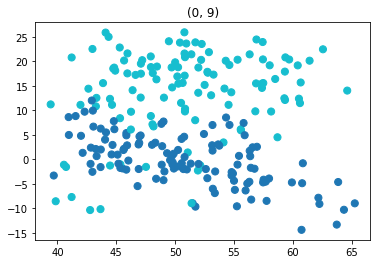

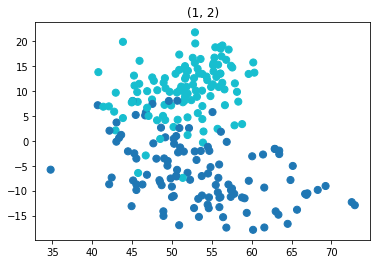

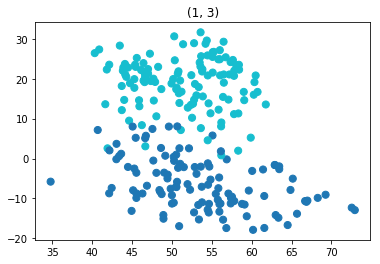

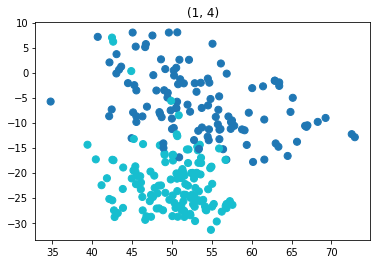

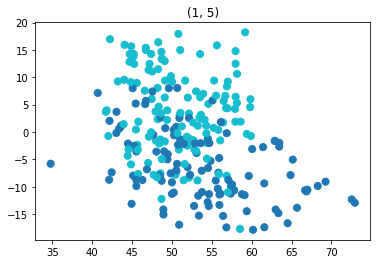

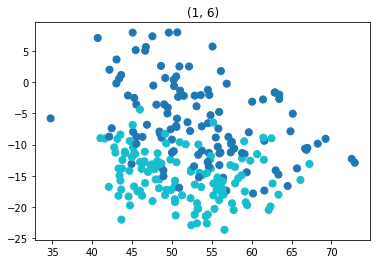

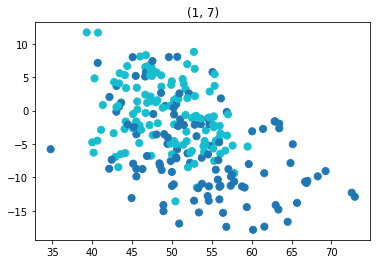

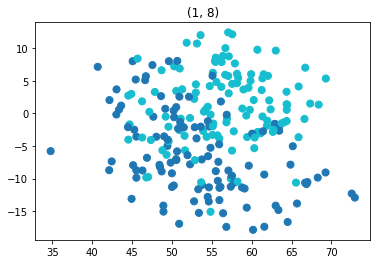

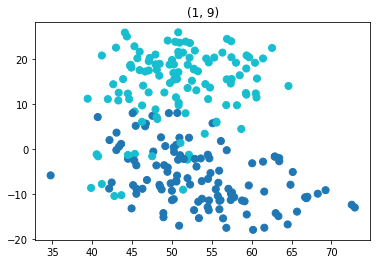

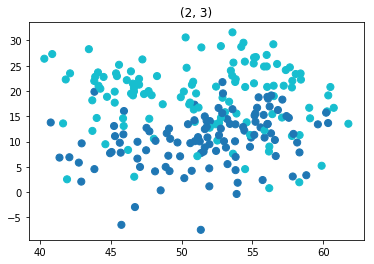

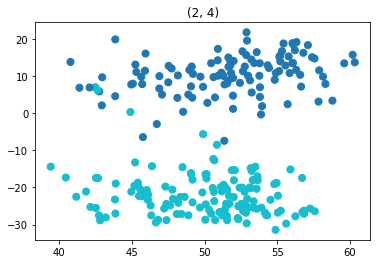

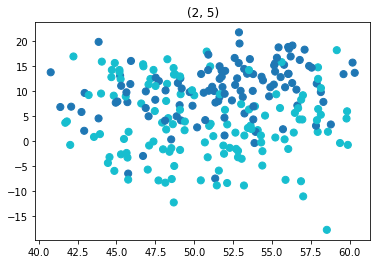

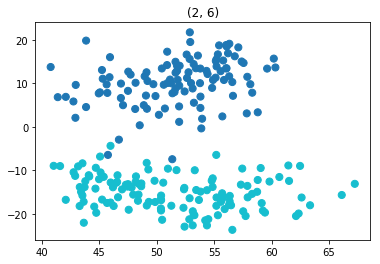

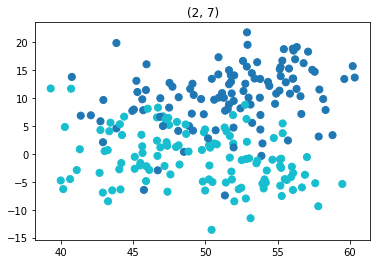

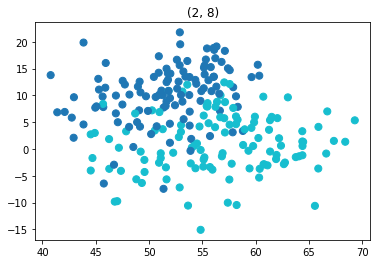

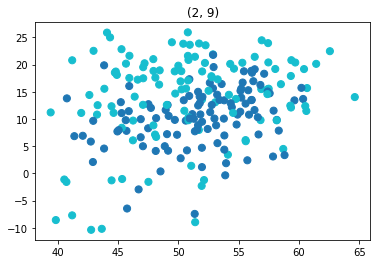

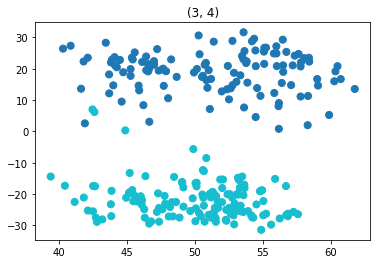

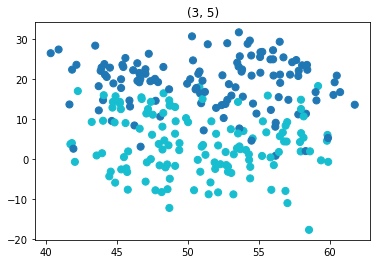

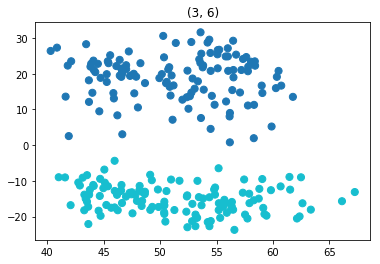

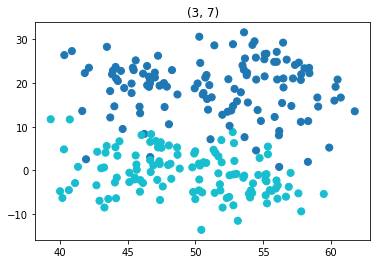

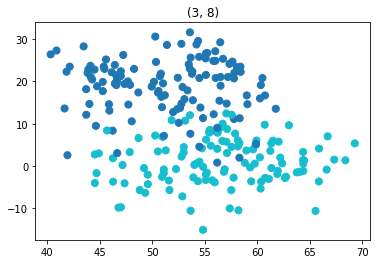

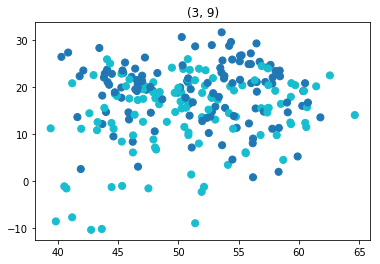

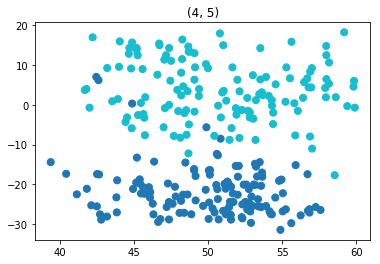

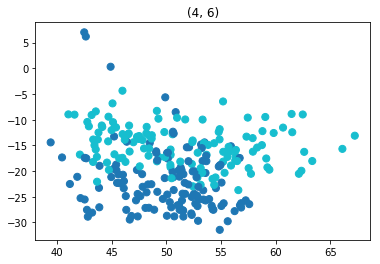

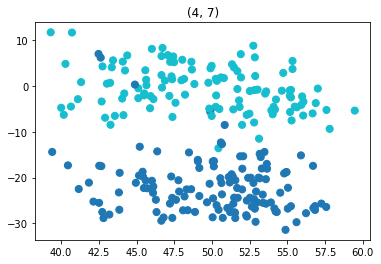

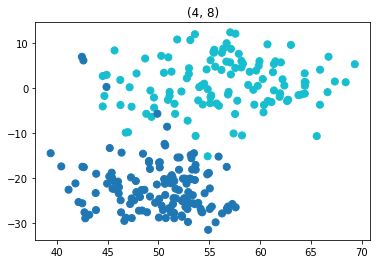

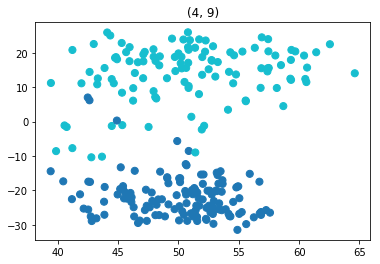

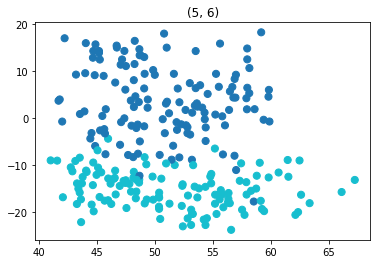

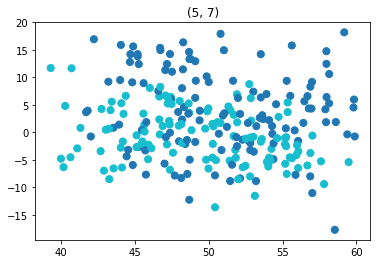

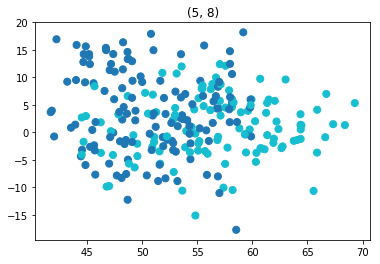

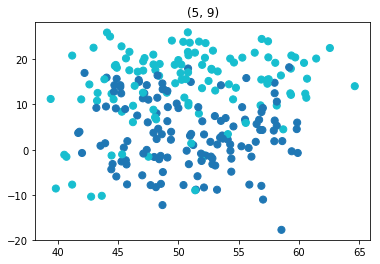

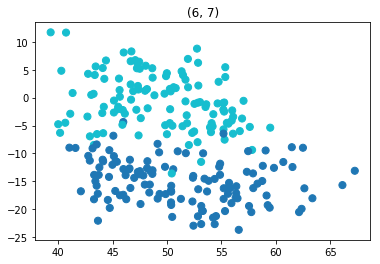

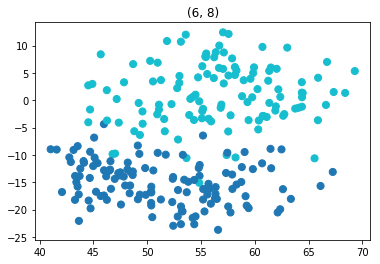

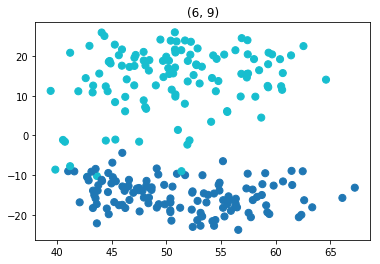

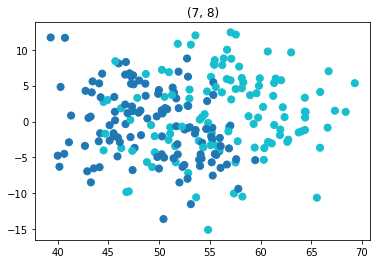

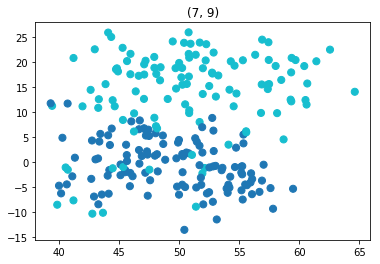

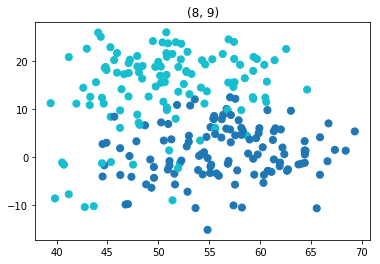

In [27]:
for c in combinations(set(y_train), 2):
    # Draw a scatter plot for each combination of classes
    plt.figure()
    plt.scatter(transformed_X_train[(y_train == c[0]) | (y_train == c[1])][:, 0],
                transformed_X_train[(y_train == c[0]) | (y_train == c[1])][:, 1],
                c = y_train[(y_train == c[0]) | (y_train == c[1])], cmap='tab10', s=50)
    plt.title(c)

Give a brief interpretation of the scatter plot. Which classes look like hard to distinguish? Do both feature dimensions contribute to the class separability? 

** My answer here: ** Some classes such as 0 and 2 or 0 and 5 are hard to distinguish. Both feature dimensions contribute best to the class seprarability of classes like 0 and 4 or 3 and 4.

#### Problem 3(c) 

Write a **ten-fold cross validation** to estimate the optimal value for $k$ for the digits data set. *However*, this time we are interested in the influence of the number of dimensions we project the data down as well. 

Extend the cross validation as done for the iris data set, to optimize $k$ for different dimensional projections of the data. Create a boxplot showing test scores for the optimal $k$ for each $d$-dimensional subspace with $d$ ranging from one to ten. The plot should have the scores on the y-axis and the different dimensions $d$ on the x-axis. We can use my favorite plot function for the boxplots. [Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/index.html) is worth having a look at though. It is a great library for statistical visualization and of course also comes with a [`boxplot`](http://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.boxplot.html) function that has simple means for changing the labels on the x-axis.

In [28]:
clf = KNeighborsClassifier()
svd = TruncatedSVD()
score = []
k = []
for d in range(1, 11):
    # Initiate a gridsearh optimising for accuracy with n_neighbors ranging from 1 to 50 and cv = 10
    grid = GridSearchCV(clf, param_grid={'n_neighbors': range(1, 51)}, scoring='accuracy', cv=10)
    # Fit the SVD model and transform the data with n_components ranging from 1 to 10
    svd.set_params(n_components=d)
    grid.fit(svd.fit_transform(X_train), y_train)
    # Record the mean test score for each cross validation fold
    score.append(grid.cv_results_['mean_test_score'])
    # Record the best k for each n_components
    k.append(grid.best_params_['n_neighbors'])

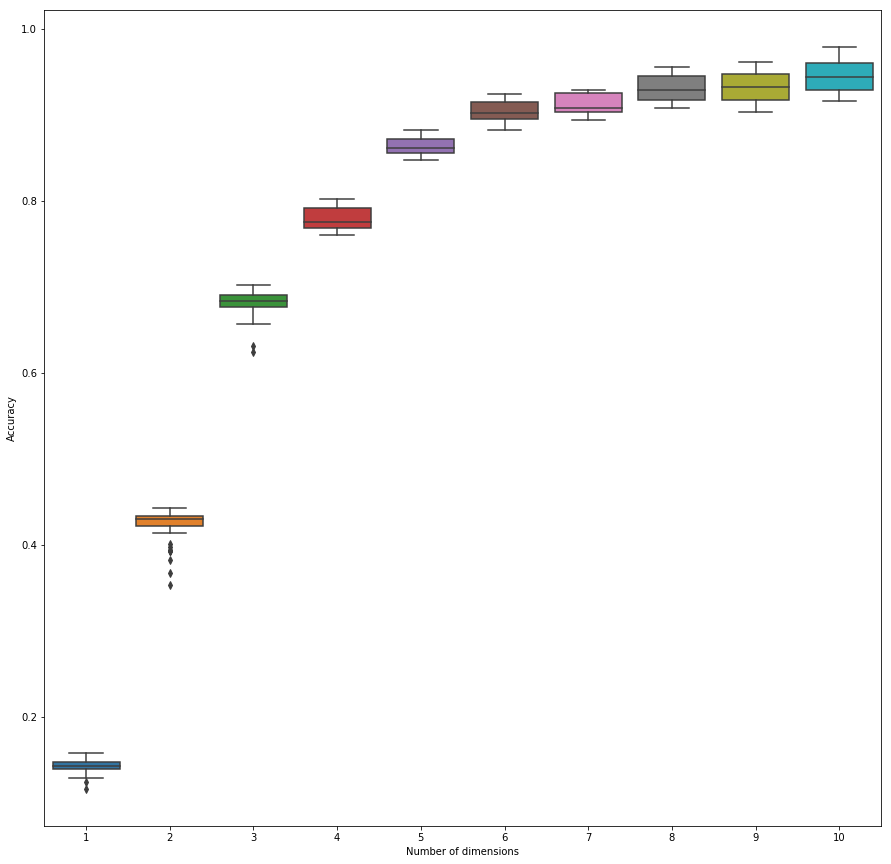

In [29]:
plt.figure(figsize=(15, 15))
sns.boxplot(list(range(1, 11)), score)
plt.xlabel('Number of dimensions')
plt.ylabel('Accuracy')

Write a short interpretation of the generated plot, answering the following questions:

* What trend do we see in the plot for increasing dimensions?

* Why do we think this is happening?

** My answer here: ** As we increase the number of dimensions, the accuracy of our model increases as the model was able to capture more variance in the data. However, there would be a point where more dimensions could not help explain the data much better and not improve the accuracy further.

#### Problem 3(d) 

**For AC209 Students**: Change the boxplot we generated above to also show the optimal value for $k$ chosen by the cross validation grid search. 

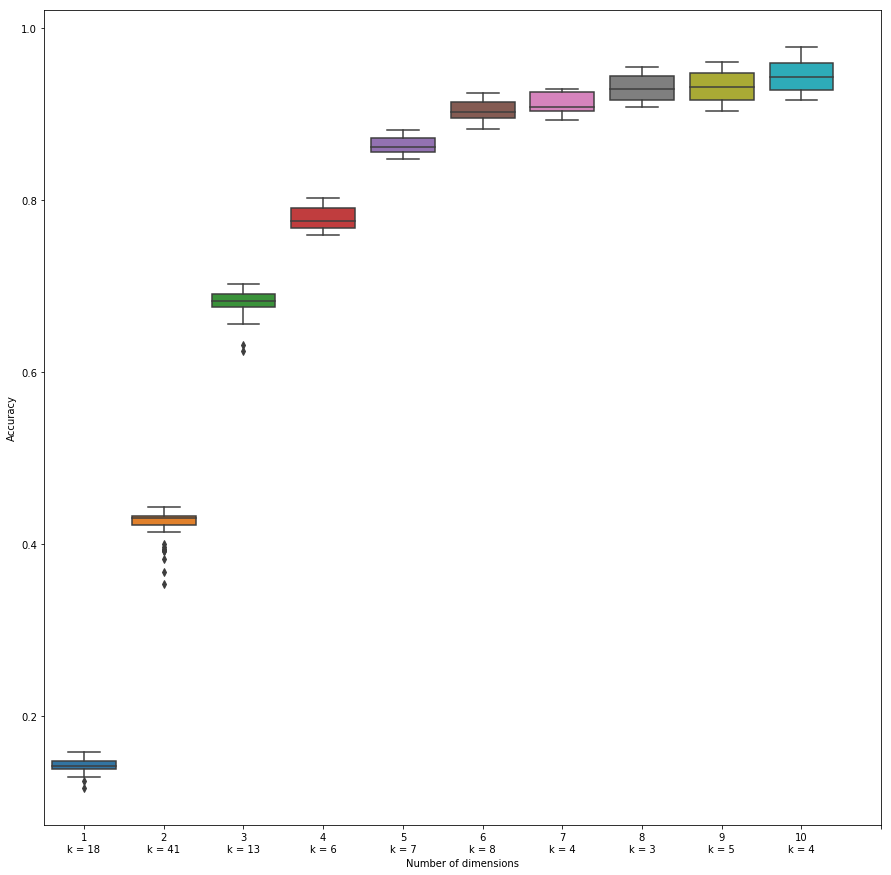

In [30]:
plt.figure(figsize=(15, 15))
sns.boxplot(list(range(1, 11)), score)
plt.xticks(range(11), [str(idx+1) + '\nk = ' + str(v) for idx, v in enumerate(k)])
plt.xlabel('Number of dimensions')
plt.ylabel('Accuracy')

Write a short interpretation answering the following questions:

* Which trend do we observe for the optimal value of $k$?

* Why do we think this is happening?

** My answer here: **The optimal value of k ultimately decreased when we increase the number of dimensions. As the model include higher dimensions, the data become increasingly sparse that the search radius for higher k becomes so large and starts to include points from other classes.

---